# CapStone Project: Authentication Risk Assessment

**Goal**: The primary goal is to develop an authentication risk assessment system for a banking application(s) that can accurately classify customer login attempts as 'normal' or 'anomalous' (abnormal).


**Current Challenge**: Traditional authentication methods often rely on static authentication policies, which doesn't offer a great combination of user experience and security. The challenge includes managing the trade-off between false positives (legitimate users inconvenienced with multiple factors) and false negatives (missed security threats).


**Proposed Solution**: Leverage advanced machine learning models, including unsupervised techniques like Isolation Forest and One-Class SVM for anomaly detection, and supervised methods like Random Forest for classification. These models can analyze customer login event data (e.g., time of day, geographical location, device type) to identify patterns indicative of suspicious activity.


**Potential Benefits**: This machine learning solution aims to enhance security and improving user experience for normal login events.
Automation of login anomaly detection also reduces the burden on security operations teams, allowing them to focus on investigating high-priority threats rather than sifting through vast amounts of data manually.


**Solution Approach**: In this capstone project, goal is to analyze the customer login events (for a banking application) to predict normal/anomalous (abnormal) login attempt. Classification of login behaviour will help decide the approprite action - to allow the user to login with regular authentication flow or to require additional/strong authentication or to block/alert the authentication attempt.
We plan to leverage multiple models, namely (KMeans in part 1) Isolation Forest, Random Forest, and One Class SVM.    


## Getting Started

Our dataset comes from customer login data from Customer Identity and Access Management (IAM) event logs. This data has been anonymized (including synthetic values for select columns) and select column have been removed (with no or low impact on prediction).

**Part 2 (final):**
This notebook is the final part of project. In this exercise, we start with tuning Isolation Forest. Outcome of Isolation forest has been used to define target feature (risk category) which will an input to Random Forest model. In addition to Random Forest, We have implemented One Class SVM to predict abnormal login events and results/performance of both models has been compared.


Note: We have completed Exploratory Data Analysis (EDA) and Basic modelling in Part 1.



### Refining the features
In Part 1, we created a new feature named state_category with value representing 'top 20 US states' categorization. Using basic Isolation Forest and Random Forest, percentage of outliers (abnormal events) turned out to approx 5% of total events. We need little more data for abnormal events.
In order to achieve so, in this exercise we will update the 'top 20 US states' categorization to 'top 15 US states' categorization' which should result in relatively higher number of events falling outside 'top 15 US states' categorization.
We are also tuning contamination parameter value to 0.20 for Isolation Forest run. Outcome of Isolation Forest is used to develop anomaly prediction feature (used as target feature for Random Forest model).

I have looked at Synthetic Minority Over-sampling Technique (SMOTE) alternative to inscrease abnormal data points. However, I decided in favor of tweaking features and using Isolation Forest with contamination parameter for this exercise.
In a real world situation, We could have bigger dataset and better computing resources (for GridSearchCV type operations).




Use pandas to read in the dataset `login_events_final.csv` and assign to a meaningful variable name.

In [ ]:
import pandas as pd
df_login_events = pd.read_csv('data/login_events_final.csv')
df_login_events.info()
df_login_events.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107340 entries, 0 to 107339
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   timestamp           107340 non-null  object
 1   user_id             107340 non-null  int64 
 2   client_device_type  107340 non-null  object
 3   client_country      107340 non-null  object
 4   request_ip_state    107288 non-null  object
 5   time_of_day         107340 non-null  int64 
 6   country_category    107340 non-null  int64 
 7   state_category      107340 non-null  int64 
 8   device_category     107340 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 7.4+ MB


,timestamp,user_id,client_device_type,client_country,request_ip_state,time_of_day,country_category,state_category,device_category
0,2026-01-01 04:52:18.309999943,10000,Computer,United States,Michigan,4,1,4,1
1,2026-01-01 04:40:38.510999918,10001,Computer,United States,Maryland,4,1,5,1
2,2026-01-01 04:57:53.970000029,10002,Mobile,United States,Alabama,4,1,5,0
3,2026-01-01 04:28:47.693000078,10003,Computer,United States,District of Columbia,4,1,5,1
4,2026-01-01 04:23:37.773999929,10004,Computer,United States,Kentucky,4,1,5,1
5,2026-01-01 04:28:38.298000097,10005,Computer,United States,South Carolina,4,1,5,1
6,2026-01-01 04:28:43.628999949,10006,Mobile,United States,Georgia,4,1,5,0
7,2026-01-01 03:58:05.654999971,10007,Mobile,United States,Unknown_State,3,1,3,0
8,2026-01-01 04:17:25.875000000,10008,Mobile,United States,Georgia,4,1,5,0
9,2026-01-01 04:17:37.687000036,10009,Computer,United States,North Carolina,4,1,5,1


Update the 'top 20 US states' categorization to 'top 15 US states' categorization' which will result in higher number of events falling outside 'top 15 US states' categorization.

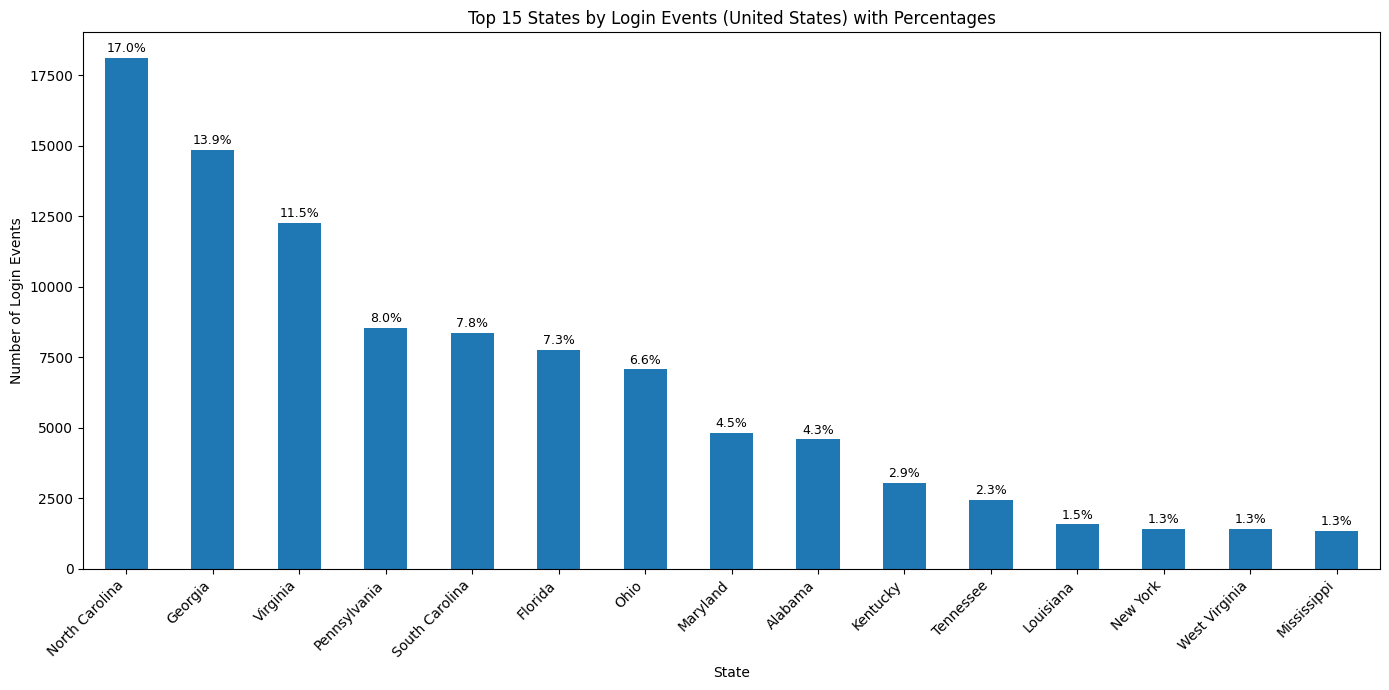

Total percentage of login events from the top 15 states: 91.51%


In [ ]:
import matplotlib.pyplot as plt

us_login_events_cleaned = df_login_events[df_login_events['client_country'] == 'United States']

top_15_states_counts = us_login_events_cleaned['request_ip_state'].value_counts().head(15)
total_us_logins = us_login_events_cleaned['request_ip_state'].count()
top_15_states_percentages = (top_15_states_counts / total_us_logins) * 100

plt.figure(figsize=(14, 7))
ax = top_15_states_counts.plot(kind='bar')
plt.title('Top 15 States by Login Events (United States) with Percentages')
plt.xlabel('State')
plt.ylabel('Number of Login Events')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of the bars
for i, (count, percentage) in enumerate(zip(top_15_states_counts, top_15_states_percentages)):
    ax.text(i, count + 100, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

total_top_15_percentage = top_15_states_percentages.sum()
print(f"Total percentage of login events from the top 15 states: {total_top_15_percentage:.2f}%")

In [ ]:
import numpy as np

top_15_state_names = top_15_states_counts.index.tolist()

conditions = [
    (df_login_events['client_country'] == 'United States') & (df_login_events['request_ip_state'].isin(top_15_state_names)),
    (df_login_events['client_country'] == 'United States') & (df_login_events['request_ip_state'] == 'Unknown_State'),
    (df_login_events['client_country'] == 'United States') & (~df_login_events['request_ip_state'].isin(top_15_state_names)) & (df_login_events['request_ip_state'] != 'Unknown_State'),
    (df_login_events['client_country'] != 'United States') & (df_login_events['request_ip_state'] != 'Unknown_State'),
    (df_login_events['client_country'] != 'United States') & (df_login_events['request_ip_state'] == 'Unknown_State')
]

choices = [
    'Top 15 US State',
    'Unknown US State',
    'Remaining US State',
    'International State',
    'Unknown International State'
]

df_login_events['state_category'] = np.select(conditions, choices, default='Other') # 'Other' for any unforeseen edge cases

print("Value counts for the new 'state_category' column:")
print(df_login_events['state_category'].value_counts())

df_login_events.head()

Value counts for the new 'state_category' column:
state_category
Top 15 US State                97549
Remaining US State              8534
Unknown US State                 566
International State              384
Unknown International State      307
Name: count, dtype: int64


,timestamp,user_id,client_device_type,client_country,request_ip_state,time_of_day,country_category,state_category,device_category
0,2026-01-01 04:52:18.309999943,10000,Computer,United States,Michigan,4,1,Remaining US State,1
1,2026-01-01 04:40:38.510999918,10001,Computer,United States,Maryland,4,1,Top 15 US State,1
2,2026-01-01 04:57:53.970000029,10002,Mobile,United States,Alabama,4,1,Top 15 US State,0
3,2026-01-01 04:28:47.693000078,10003,Computer,United States,District of Columbia,4,1,Remaining US State,1
4,2026-01-01 04:23:37.773999929,10004,Computer,United States,Kentucky,4,1,Top 15 US State,1


Show distribution of login events by updated state category.

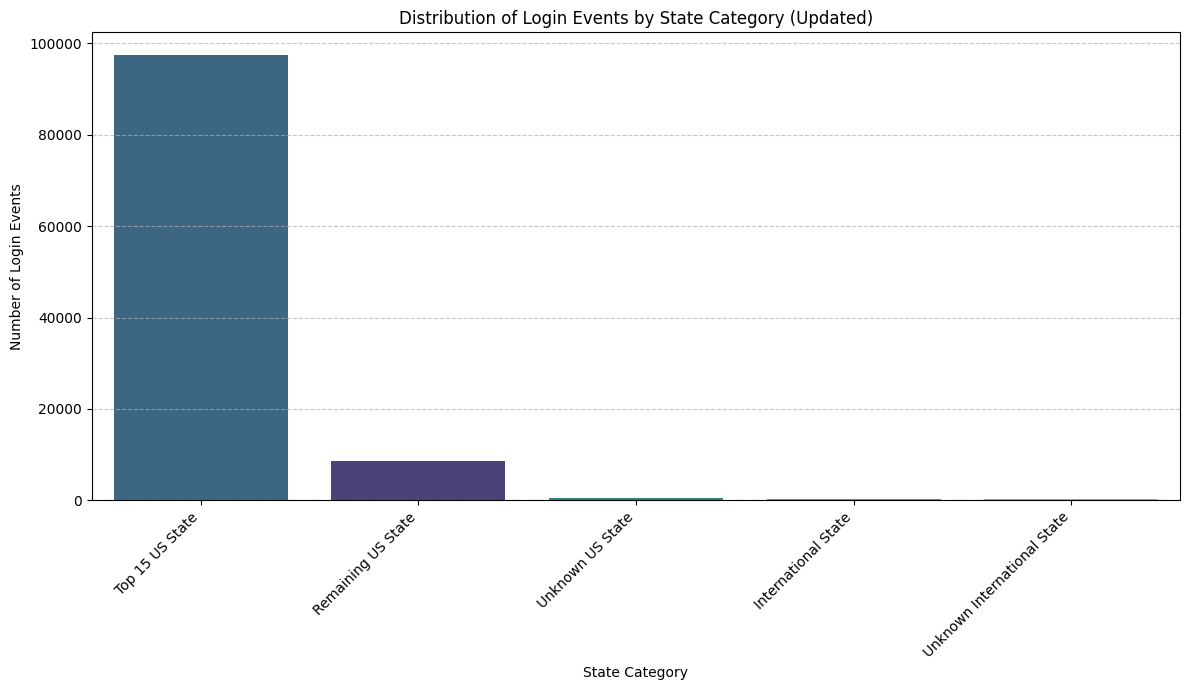

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.countplot(data=df_login_events, x='state_category', hue='state_category', palette='viridis', legend=False, order=df_login_events['state_category'].value_counts().index)
plt.title('Distribution of Login Events by State Category (Updated)')
plt.xlabel('State Category')
plt.ylabel('Number of Login Events')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Convert state_category to numeric values (to prepare of modeling).

In [ ]:
import numpy as np
import pandas as pd


# Check if 'state_category' is already numerically encoded
if not pd.api.types.is_integer_dtype(df_login_events['state_category']):
    state_category_mapping = {
        'Top 15 US State': 5,
        'Remaining US State': 4,
        'Unknown US State': 3,
        'International State': 2,
        'Unknown International State': 1
    }

    # Apply the numerical mapping
    df_login_events['state_category'] = df_login_events['state_category'].map(state_category_mapping).fillna(0).astype(int)
    print("State category encoded to numerical values using 'Top 15 US State' logic.")
else:
    print("'state_category' is already numerically encoded.")

print("Unique values and counts for 'state_category' after encoding:")
print(df_login_events['state_category'].value_counts())
print(f"\nData type of 'state_category' column: {df_login_events['state_category'].dtype}")

State category encoded to numerical values using 'Top 15 US State' logic.
Unique values and counts for 'state_category' after encoding:
state_category
5    97549
4     8534
3      566
2      384
1      307
Name: count, dtype: int64

Data type of 'state_category' column: int64


The state category has been successfully re-encoded to numerical values using the 'Top 15 US State' logic. The updated value counts for 'state_category' are now:


* Category 5 (Top 15 US State): 97549 events
* Category 4 (Remaining US State): 8534 events
* Category 3 (Unknown US State): 566 events
* Category 2 (International State): 384 events
* Category 1 (Unknown International State): 307 events

## Isolation Forest Model
The Isolation Forest model is an unsupervised machine learning algorithm primarily used for anomaly detection.

In this project, Isolation Forest is used to identify unusual or anomalous login attempts. Given the nature of security events, anomalies (like fraudulent logins) are expected to be rare compared to legitimate logins. Isolation Forest is well-suited for this task because:

In our notebook, we set a `contamination` parameter of `0.20`, meaning the model is instructed to expect approximately 20% of the data to be anomalies. This helps in defining the threshold for classifying a login as an outlier.
We have removed country_category feature (compared to part 1) as this information is captured in state_category.

In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline

# We will use time_of_day, state_category and device_category
X_features = df_login_events[['time_of_day', 'state_category', 'device_category']]

# Create a pipeline with IsolationForest only
pipeline_iso = Pipeline([
    ('isoforest', IsolationForest(n_estimators=100, contamination=0.20, random_state=42, n_jobs=-1))
])

# Fit the pipeline to the data
pipeline_iso.fit(X_features)

# Get the fitted IsolationForest model from the pipeline
iso_forest_model = pipeline_iso.named_steps['isoforest']

# Predict anomaly scores (lower score indicates higher anomaly)
anomaly_scores = pipeline_iso.decision_function(X_features)

# Predict whether a sample is an outlier or not (-1 for outliers and 1 for inliers)
anomaly_predictions = pipeline_iso.predict(X_features)

# Add the anomaly scores and predictions to a copy of the features DataFrame for display
X_with_anomalies = X_features.copy()
X_with_anomalies['anomaly_score'] = anomaly_scores
X_with_anomalies['anomaly_prediction'] = anomaly_predictions

print("\nAnomaly prediction distribution:")
print(X_with_anomalies['anomaly_prediction'].value_counts())

print("\nInterpretation of Anomaly Prediction:")
print("-  1: Inlier (normal data point)")
print("- -1: Outlier (anomalous data point)")


Anomaly prediction distribution:
anomaly_prediction
 1    86614
-1    20726
Name: count, dtype: int64

Interpretation of Anomaly Prediction:
-  1: Inlier (normal data point)
- -1: Outlier (anomalous data point)


Analyze distribution of features between Inliers and Outliers.



In [ ]:
import pandas as pd

outliers_data = X_with_anomalies[X_with_anomalies['anomaly_prediction'] == -1].copy()
inliers_data = X_with_anomalies[X_with_anomalies['anomaly_prediction'] == 1].copy()

print("--- Comparison of Outliers vs. Inliers ---")
print(f"Total Outliers: {len(outliers_data)}")
print(f"Total Inliers: {len(inliers_data)}")

print("\n--- Time of Day ---")
print(f"Mean time_of_day for Outliers: {outliers_data['time_of_day'].mean():.2f}")
print(f"Mean time_of_day for Inliers: {inliers_data['time_of_day'].mean():.2f}")


print("\n--- State Category Distribution ---")
print("Outliers:\n", outliers_data['state_category'].value_counts(normalize=True))
print("Inliers:\n", inliers_data['state_category'].value_counts(normalize=True))

print("\n--- Device Category Distribution ---")
print("Outliers:\n", outliers_data['device_category'].value_counts(normalize=True))
print("Inliers:\n", inliers_data['device_category'].value_counts(normalize=True))

--- Comparison of Outliers vs. Inliers ---
Total Outliers: 20726
Total Inliers: 86614

--- Time of Day ---
Mean time_of_day for Outliers: 11.67
Mean time_of_day for Inliers: 15.05

--- State Category Distribution ---
Outliers:
 state_category
5    0.527598
4    0.411753
3    0.027309
2    0.018527
1    0.014812
Name: proportion, dtype: float64
Inliers:
 state_category
5    1.0
Name: proportion, dtype: float64

--- Device Category Distribution ---
Outliers:
 device_category
1    0.569767
0    0.430233
Name: proportion, dtype: float64
Inliers:
 device_category
1    0.633627
0    0.366373
Name: proportion, dtype: float64


Visualize the feature impact for outliers vs inliers:

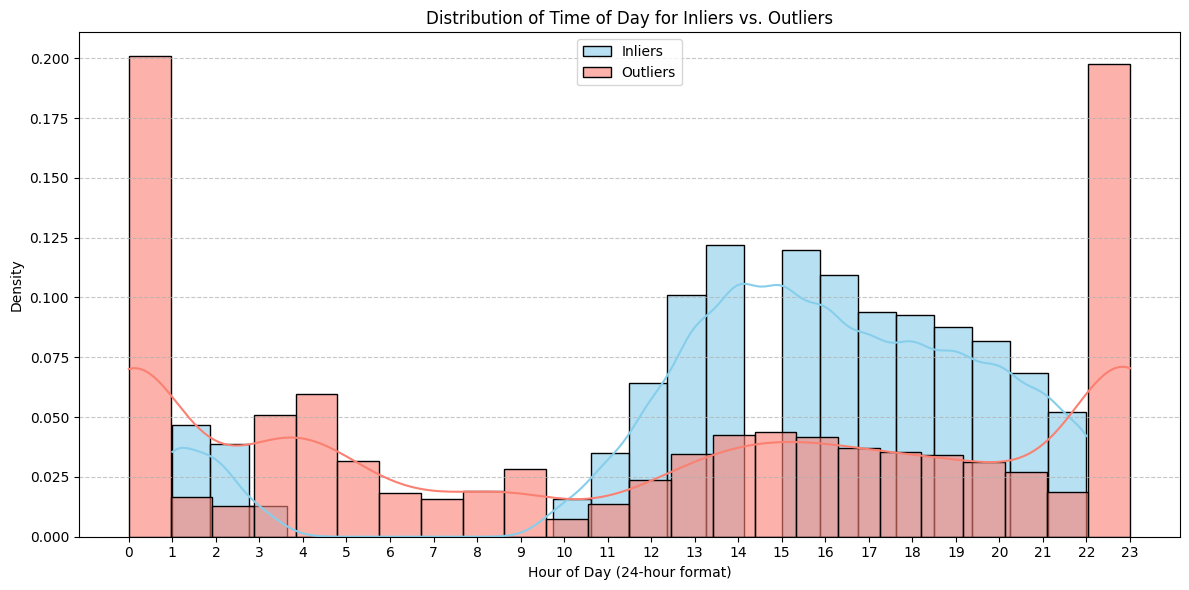

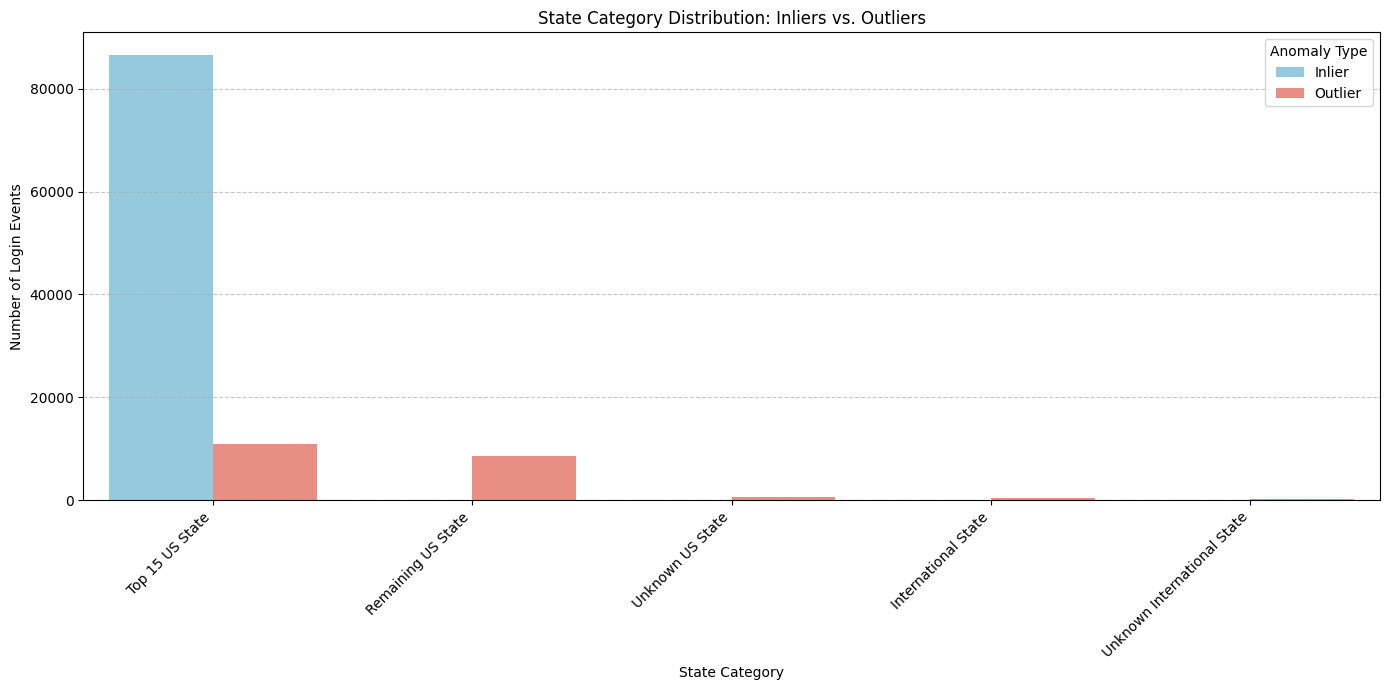

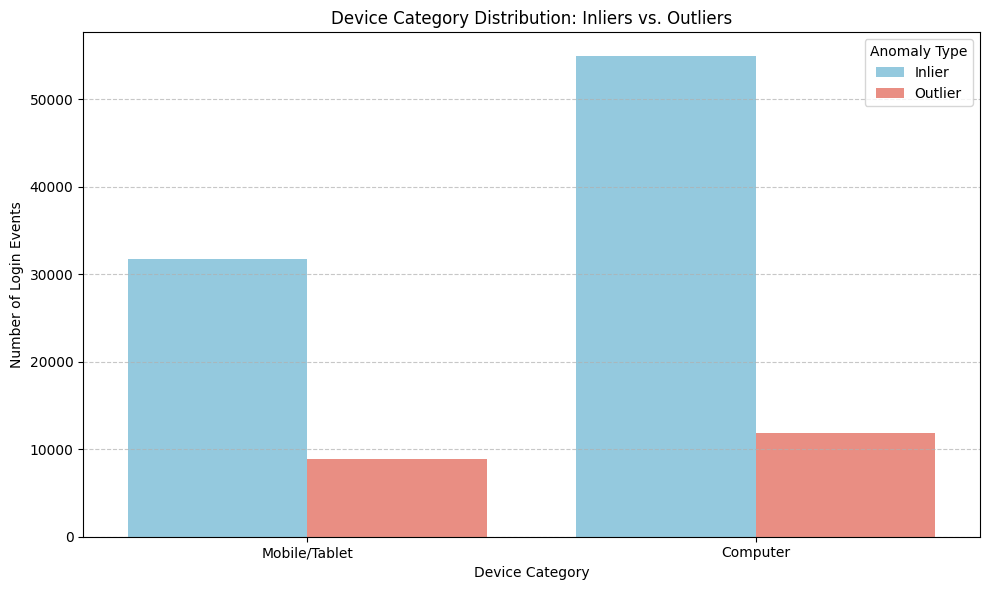

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Visualize Time of Day Distribution for Outliers vs. Inliers ---
plt.figure(figsize=(12, 6))
sns.histplot(inliers_data['time_of_day'], color='skyblue', label='Inliers', kde=True, stat='density', alpha=0.6, bins=24)
sns.histplot(outliers_data['time_of_day'], color='salmon', label='Outliers', kde=True, stat='density', alpha=0.6, bins=24)
plt.title('Distribution of Time of Day for Inliers vs. Outliers')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Density')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- Visualize State Category Distribution for Outliers vs. Inliers in a single graph ---
combined_state_data = pd.concat([
    inliers_data.assign(type='Inlier'),
    outliers_data.assign(type='Outlier')
])

# Map numerical state categories back to their original string labels for better readability in the plot
state_category_labels = {
    5: 'Top 15 US State',
    4: 'Remaining US State',
    3: 'Unknown US State',
    2: 'International State',
    1: 'Unknown International State'
}
combined_state_data['state_category_label'] = combined_state_data['state_category'].map(state_category_labels)

plt.figure(figsize=(14, 7))
sns.countplot(data=combined_state_data, x='state_category_label', hue='type', palette={'Inlier': 'skyblue', 'Outlier': 'salmon'}, order=combined_state_data['state_category_label'].value_counts().index)
plt.title('State Category Distribution: Inliers vs. Outliers')
plt.xlabel('State Category')
plt.ylabel('Number of Login Events')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Anomaly Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Visualize Device Category Distribution for Outliers vs. Inliers in a single graph ---
combined_device_data = pd.concat([
    inliers_data.assign(type='Inlier'),
    outliers_data.assign(type='Outlier')
])

# Map numerical device categories back to their labels for better readability
device_category_labels = {
    0: 'Mobile/Tablet',
    1: 'Computer'
}
combined_device_data['device_category_label'] = combined_device_data['device_category'].map(device_category_labels)

plt.figure(figsize=(10, 6))
sns.countplot(data=combined_device_data, x='device_category_label', hue='type', palette={'Inlier': 'skyblue', 'Outlier': 'salmon'})
plt.title('Device Category Distribution: Inliers vs. Outliers')
plt.xlabel('Device Category')
plt.ylabel('Number of Login Events')
plt.legend(title='Anomaly Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Analysis of Outliers Identified by Isolation Forest (Contamination = 0.20)

The Isolation Forest model, with a `contamination` value of 0.20, identified 20,726 outliers and 86,614 inliers.

The Isolation Forest model identifies anomalies as login events that tend to happen earlier in the day, originate from less common US states or international locations, and are somewhat more likely to come from mobile/tablet devices relative to normal login patterns. These characteristics align with typical patterns one might expect from potentially suspicious activities.

In [ ]:
# Map anomaly_prediction from the Isolation Forest model to risk_category: -1 to 0 (anomaly), 1 to 1 (normal)
df_login_events['risk_category'] = X_with_anomalies['anomaly_prediction'].replace({-1: 0, 1: 1})

print("DataFrame 'df_login_events' updated with 'risk_category' column using basic model predictions:")
display(df_login_events.head())

print("Value counts for the new 'risk_category' column:")
print(df_login_events['risk_category'].value_counts())

DataFrame 'df_login_events' updated with 'risk_category' column using basic model predictions:


,timestamp,user_id,client_device_type,client_country,request_ip_state,time_of_day,country_category,state_category,device_category,risk_category
0,2026-01-01 04:52:18.309999943,10000,Computer,United States,Michigan,4,1,4,1,0
1,2026-01-01 04:40:38.510999918,10001,Computer,United States,Maryland,4,1,5,1,0
2,2026-01-01 04:57:53.970000029,10002,Mobile,United States,Alabama,4,1,5,0,0
3,2026-01-01 04:28:47.693000078,10003,Computer,United States,District of Columbia,4,1,4,1,0
4,2026-01-01 04:23:37.773999929,10004,Computer,United States,Kentucky,4,1,5,1,0


Value counts for the new 'risk_category' column:
risk_category
1    86614
0    20726
Name: count, dtype: int64


### Split data into train/test sets
We will prepare data into training and testing sets for a supervised model (Random Forest).

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Define features (X) and target (y)
X = df_login_events[['time_of_day', 'state_category', 'device_category']]
y = df_login_events['risk_category'] # Target is the new risk_category

# Split the data into training and testing sets
# Using stratify=y to maintain the proportion of risk_category in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("Distribution of 'risk_category' in y_train:")
display(y_train.value_counts(normalize=True))

print("\nDistribution of 'risk_category' in y_test:")
display(y_test.value_counts(normalize=True))

X_train shape: (75138, 3)
X_test shape: (32202, 3)
y_train shape: (75138,)
y_test shape: (32202,)
Distribution of 'risk_category' in y_train:


,proportion
risk_category,
1,0.806915
0,0.193085



Distribution of 'risk_category' in y_test:


,proportion
risk_category,
1,0.806906
0,0.193094


## Random Forest Model (with Tuning)

Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees during training. For classification tasks, the output of the Random Forest is the class selected by most trees.

The `class_weight='balanced'` parameter used in our Random Forest pipeline helps mitigate issues with imbalanced datasets, which is common in anomaly detection (fewer anomalies than normal events).



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__min_samples_leaf': [1, 5]
}

#standard scaler and polynomial features doesn't really add value for random forest model so keeping it simple
pipeline = Pipeline([
    ('randomforestclassifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV to the training data
print("Starting GridSearchCV fit...")
grid_search.fit(X_train, y_train)
print("GridSearchCV fit complete.")

print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

print("Best F1 score:")
print(grid_search.best_score_)

Starting GridSearchCV fit...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
GridSearchCV fit complete.
Best parameters found by GridSearchCV:
{'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 100}
Best F1 score:
1.0


In [ ]:
from sklearn.metrics import classification_report

# Retrieve the best estimator
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Display the classification report
print("\nClassification Report for the Best Random Forest Model:")
print(classification_report(y_test, y_pred))

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

print("\nBest F1 score:")
print(grid_search.best_score_)


Classification Report for the Best Random Forest Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6218
           1       1.00      1.00      1.00     25984

    accuracy                           1.00     32202
   macro avg       1.00      1.00      1.00     32202
weighted avg       1.00      1.00      1.00     32202


Best parameters found by GridSearchCV:
{'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 100}

Best F1 score:
1.0


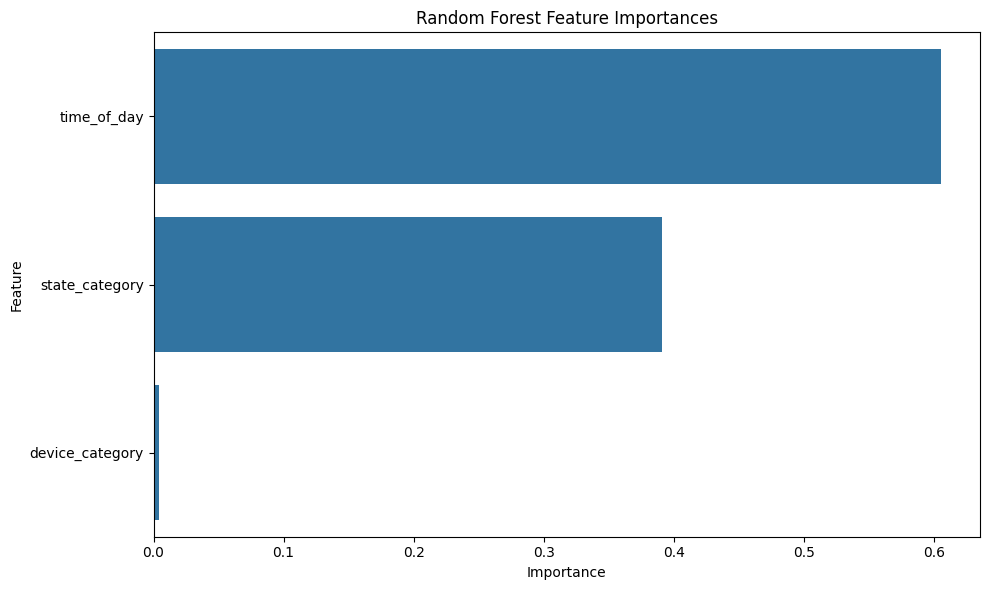

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances from the best Random Forest model
feature_importances = best_rf_model.named_steps['randomforestclassifier'].feature_importances_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Summary of Random Forest Feature Importances

Based on the Random Forest model's `feature_importances_` attribute, the following features were most influential in classifying risky login events, derived from the Isolation Forest's anomaly predictions:

1.  **time_of_day**: This was by far the most influential feature. It indicates that the time of day a login attempt occurs has the strongest impact on whether an event is classified as risky or normal. Anomalous login attempts were observed to be more frequent during off-peak hours.

2.  **state_category**: The geographical origin of the login attempt, categorized into groups like 'Top 15 US State', 'Remaining US State', 'International State', etc., was the second most important feature. Logins originating from states outside the top 15 US states or from international locations were significantly more prone to being classified as anomalous.

3.  **device_category**: The type of device used for the login (Computer vs. Mobile/Tablet) had a very minor influence on the Random Forest's classification.

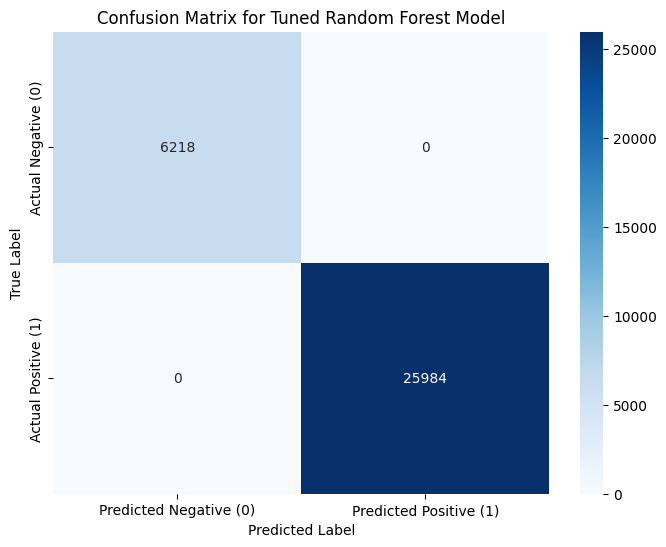

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions from the best Random Forest model
y_pred_rf = best_rf_model.predict(X_test)

# Calculate the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
            yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
plt.title('Confusion Matrix for Tuned Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Analysis of Perfect Scores in Random Forest Classification Report

The perfect scores (precision, recall, and F1-score of 1.00 for both classes) observed in the Random Forest classification report are striking and warrant a detailed explanation, especially in the context of anomaly detection.

1.  **Target Variable Generation (Key Insight)**: The most probable explanation for these perfect scores lies in how the `risk_category` (the target variable `y`) was created. We generated `risk_category` using the **Isolation Forest model** on the *entire dataset* (`df_login_events`) before splitting it into training and testing sets. The Random Forest model was then trained to predict this `risk_category`.

    *   **Random Forest is a Supervised Model**: It learned to associate the input features (`time_of_day`, `state_category`, `device_category`) with the labels provided by the Isolation Forest.
    *   **Learning the Isolation Forest's Rules**: Effectively, the Random Forest learned the exact decision boundaries that the Isolation Forest had implicitly created. Since the Isolation Forest had already 'labeled' all data points (including those in the test set) as either 'inlier' (normal) or 'outlier' (anomalous), the Random Forest's task became to accurately reproduce those labels.

2.  **No True Independent Anomaly Identification**: The Random Forest isn't detecting *new* or *previously unknown* anomalies in the test set. Instead, it's acting as a highly effective classifier for the labels *already assigned* by the Isolation Forest. This setup means it's testing how well the Random Forest can mimic the Isolation Forest's output, rather than testing its ability to find anomalies independently.

3.  **Potential for Data Leakage**: While the data was split into train/test sets, the process of creating the target `risk_category` from the *entire* dataset *before* the split can be seen as a form of **data leakage**. The Isolation Forest, when generating `risk_category`, indirectly 'saw' the characteristics of the data points that would later end up in the test set. This allowed the Random Forest to learn a perfect mapping from features to these pre-determined labels.

The perfect scores indicate that the Random Forest model was extremely successful at learning the patterns established by the Isolation Forest for defining 'risk_category'. While technically correct, it's important to understand that this doesn't necessarily mean the Random Forest is independently identifying novel anomalies with 100% accuracy in a real-world, unlabeled scenario. It's perfectly classifying the output of another anomaly detection model.

## One-Class SVM Model (with Tuning)

**One-Class Support Vector Machine (OCSVM)** is an unsupervised anomaly detection algorithm. Unlike traditional SVMs that classify data points into two or more distinct classes, the OCSVM is trained on data belonging to a single class, typically the 'normal' data.


In [ ]:
# this step with GreadSearchCV took approx 10-12 minutes
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score

param_grid_ocsvm = {
    'ocsvm__nu': [0.1, 0.15, 0.2, 0.25],
    'ocsvm__kernel': ['rbf'],
    'ocsvm__gamma': ['auto']
}


# Custom scorer for OneClassSVM
# OneClassSVM predicts -1 for outliers and 1 for inliers.
# Our target 'risk_category' is 0 for anomaly and 1 for normal.
# So, we need to map OCSVM's -1 to 0 (anomaly) and 1 to 1 (normal).
def ocsvm_f1_scorer(y_true, y_pred):
    # Map OCSVM predictions (-1, 1) to (0, 1) to match y_true
    mapped_y_pred = [0 if p == -1 else 1 for p in y_pred]
    return f1_score(y_true, mapped_y_pred, average='weighted')

# Create a pipeline with OneClassSVM only
pipeline_ocsvm_grid = Pipeline([
    ('ocsvm', OneClassSVM())
])

# Initialize GridSearchCV
grid_search_ocsvm = GridSearchCV(
    estimator=pipeline_ocsvm_grid,
    param_grid=param_grid_ocsvm,
    cv=3,
    scoring=make_scorer(ocsvm_f1_scorer), # Use the custom scorer
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV to the training data
# Note: OneClassSVM is typically unsupervised, but when used with GridSearchCV for anomaly detection
# and evaluated against a 'risk_category', we provide the 'y_train' as a reference for scoring.
# The OCSVM itself does not use y_train during its fit, only X_train.
print("Starting GridSearchCV fit for OneClassSVM...")
grid_search_ocsvm.fit(X_train, y_train)
print("GridSearchCV fit for OneClassSVM complete.")

print("\nBest parameters found by GridSearchCV for OneClassSVM:")
print(grid_search_ocsvm.best_params_)

print("\nBest F1-weighted score for OneClassSVM:")
print(grid_search_ocsvm.best_score_)

Starting GridSearchCV fit for OneClassSVM...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
GridSearchCV fit for OneClassSVM complete.

Best parameters found by GridSearchCV for OneClassSVM:
{'ocsvm__gamma': 'auto', 'ocsvm__kernel': 'rbf', 'ocsvm__nu': 0.25}

Best F1-weighted score for OneClassSVM:
0.635569020427266


Evaluate One-Class SVM with the best parameters found in above step. Run the prediction and display the classification report for the best One-Class SVM model.

In [ ]:
from sklearn.metrics import classification_report

# Retrieve the best estimator for OneClassSVM
best_ocsvm_model = grid_search_ocsvm.best_estimator_

# Make predictions on the test set
# OCSVM's predict method returns -1 for outliers and 1 for inliers
y_pred_ocsvm_raw = best_ocsvm_model.predict(X_test)

# Map OCSVM predictions (-1, 1) to (0, 1) to match y_test
y_pred_ocsvm = [0 if p == -1 else 1 for p in y_pred_ocsvm_raw]

# Display the classification report
print("\nClassification Report for the Best One-Class SVM Model:")
print(classification_report(y_test, y_pred_ocsvm))


Classification Report for the Best One-Class SVM Model:
              precision    recall  f1-score   support

           0       0.31      0.90      0.46      6218
           1       0.96      0.53      0.68     25984

    accuracy                           0.60     32202
   macro avg       0.63      0.71      0.57     32202
weighted avg       0.83      0.60      0.64     32202



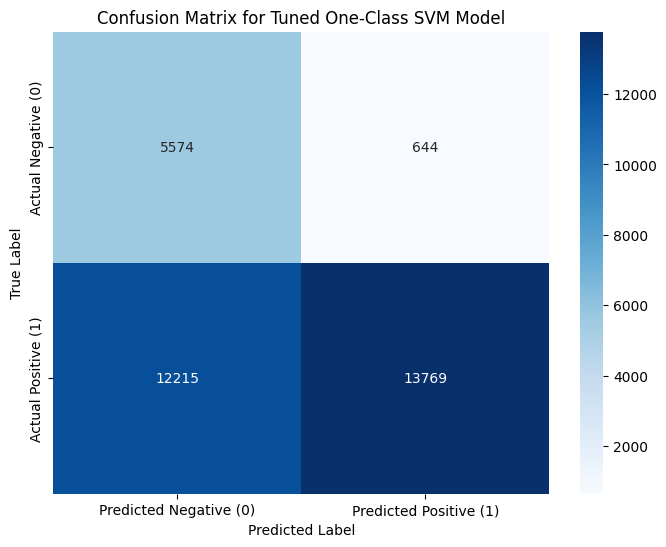

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix for OCSVM
cm_ocsvm = confusion_matrix(y_test, y_pred_ocsvm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ocsvm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
            yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
plt.title('Confusion Matrix for Tuned One-Class SVM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Comparison of One-Class SVM and Random Forest Models

### Random Forest Model (Tuned):

```
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6218
           1       1.00      1.00      1.00     25984

    accuracy                           1.00     32202
   macro avg       1.00      1.00      1.00     32202
weighted avg       1.00      1.00      1.00     32202
```

*   **Summary**: The Random Forest model achieved perfect scores (1.00 for precision, recall, and F1-score) for both anomalous (Class 0) and normal (Class 1) events, resulting in 100% accuracy. This indicates that it perfectly classified all instances in the test set.
*   **Implication**: As previously discussed, such perfect performance in an anomaly detection scenario is highly unusual and suggests that the target variable (`risk_category`) derived from the Isolation Forest provided a very clear separation that the Random Forest model could easily learn. It implies either the features are extremely indicative of the labels, or there's a potential data leakage where the model implicitly saw the test set during its label generation step.

### One-Class SVM Model (Tuned):

```
              precision    recall  f1-score   support

           0       0.31      0.90      0.46      6218
           1       0.96      0.53      0.68     25984

    accuracy                           0.60     32202
   macro avg       0.63      0.71      0.57     32202
weighted avg       0.83      0.60      0.64     32202
```

*   **Summary**: The One-Class SVM model shows more nuanced performance metrics.
    *   For **Anomalous Events (Class 0)**: It has a high recall (0.90), meaning it catches most of the actual anomalies. However, its precision (0.31) is low, indicating a high number of false positives (normal events incorrectly flagged as anomalies).
    *   For **Normal Events (Class 1)**: It has very high precision (0.96), meaning when it predicts an event is normal, it's usually correct. But its recall (0.53) is lower, indicating it misses many actual normal events, classifying them as anomalous.
    *   Overall, the accuracy is 0.60, and the weighted average F1-score is 0.64.


### Key Findings & Recommendations:

### 1. Key Insights from Model Analysis:

*   **Random Forest Model**: Achieved perfect scores (precision, recall, F1-score of 1.00) for both anomalous and normal events. This exceptional performance is largely attributed to the target `risk_category` being generated by the Isolation Forest model on the *entire dataset* before the train-test split. The Random Forest essentially learned to perfectly replicate the Isolation Forest's output, indicating a potential data leakage scenario rather than independent anomaly detection.
*   **One-Class SVM Model**: Presented more realistic performance, with a weighted average F1-score of 0.64. For anomalous events (Class 0), it demonstrated high recall (0.90) but low precision (0.31), meaning it caught most anomalies but also generated a significant number of false alarms. For normal events (Class 1), it had high precision (0.96) but lower recall (0.53). This reflects the typical trade-off in unsupervised anomaly detection, where the model aims to cast a wide net to detect potential threats.
*   **Most Influential Features (Random Forest)**: `time_of_day` was the most important feature, followed by `state_category`. `device_category` had the least impact on the Random Forest's predictions.

### 2. Recommendations for Improving Models:

*   **Feature Engineering**: Explore more sophisticated feature engineering. Consider features such as:
    *   **User-specific login frequency**: How often does a user log in, and does the current attempt deviate?
    *   **Deviation from historical patterns**: Is the login time, device, or location unusual for *this specific user*?
    *   **IP reputation**: Incorporate external data sources for IP address risk scores.
    *   **Sequential patterns**: Analyze sequences of login attempts to detect suspicious behavior chains.
*   **Explore Other Anomaly Detection Algorithms**: Investigate other unsupervised or semi-supervised methods:
    *   **Autoencoders**: Neural networks for dimensionality reduction that can identify anomalies as data points with high reconstruction error.
*   **Re-evaluate Isolation Forest's `contamination` Parameter**: Tune the `contamination` parameter for Isolation Forest based on actual domain knowledge.

### 3. Recommendations for Balancing False Positives and False Negatives:

*   **Cost-Sensitive Learning/Threshold Adjustment**: In security contexts, the cost of a **false negative** (a missed anomaly that could be a breach) is often significantly higher than a **false positive** (a legitimate login flagged as suspicious). Therefore:
    *   Adjust decision thresholds of models (e.g., for Isolation Forest's anomaly scores or a supervised model's prediction probabilities) to favor higher recall for the anomaly class, even if it slightly increases false positives.
    *   Implement cost-sensitive learning techniques during model training if a supervised approach is used, assigning higher penalties to false negatives.
*   **Human-in-the-Loop System**: Implement a system where flagged anomalies are routed to security analysts for review. This allows for validation of model predictions, reducing the impact of false positives.
